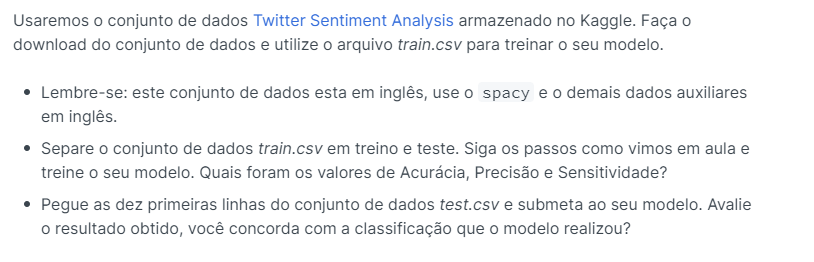

In [ ]:
import numpy as np
import pandas as pd

import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

!python -m spacy download en_core_web_sm

# label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist
tweet = pd.read_csv('/content/train.csv')
tweet.head()

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 5.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
nlp = spacy.load('en_core_web_sm')

texto = tweet.tweet[0]

print('--------------')
print('Texto original')
print(texto)

doc = nlp(texto)
tokens_filtrado = [token for token in doc if ((not token.is_stop) & (not token.is_punct))]

print('--------------')
print('Remoção de stopwords e pontuação')
print(tokens_filtrado)

lemmas = [token.lemma_.lower().strip() for token in tokens_filtrado]

print('--------------')
print('Lemmatization')
print(lemmas)

--------------
Texto original
 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
--------------
Remoção de stopwords e pontuação
[ , @user, father, dysfunctional, selfish, drags, kids, dysfunction,   , run]
--------------
Lemmatization
['', '@user', 'father', 'dysfunctional', 'selfish', 'drag', 'kid', 'dysfunction', '', 'run']


In [ ]:
# Criamos uma classe para gerenciar X e y
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Esta funcao remove espacos em branco no inicio e
# no fim do texto e converte todo o texto em letras
# minusculas
def clean_text(texto):     
    return texto.strip().lower()

# Esta funcao remove todas as stopwords e pontuacoes
def tokenizer(texto):
    doc = nlp(texto)
    tokens = [token for token in doc if ((not token.is_stop) & (not token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    return tokens

# Criamos um objeto CountVectorizer para vetorizar cada
# texto
vectorizer = CountVectorizer(tokenizer = tokenizer, ngram_range=(1,1)) 

# Criamos um modelo SVM
classifier = SVC()

In [ ]:
# Separando em X e y
X = tweet['tweet']
y = tweet['label']

# Separando em teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Construindo uma pipeline
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print(round(accuracy_score(y_test, y_pred), 3))
print(round(precision_score(y_test, y_pred, average='macro'), 3))
print(round(recall_score(y_test, y_pred, average='macro'), 3))

0.958
0.951
0.72


In [ ]:
pd.read_csv('/content/test.csv').head(10)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
5,31968,choose to be :) #momtips
6,31969,something inside me dies ð¦ð¿â¨ eyes nes...
7,31970,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...
8,31971,@user @user @user i will never understand why...
9,31972,#delicious #food #lovelife #capetown mannaep...


In [ ]:
text_data = pd.read_csv('/content/test.csv')['tweet'].head(10)

y_pred = pipe.predict(text_data)

In [ ]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

A única frase classificada como racista é a segunda (indice 1)

In [ ]:
pd.read_csv('/content/test.csv')['tweet'].head(10)[1]

' @user #white #supremacists want everyone to see the new â\x80\x98  #birdsâ\x80\x99 #movie â\x80\x94 and hereâ\x80\x99s why  '

Em tradução livre: "supremacistas brancos querem que todos vejam o novo filme 'Birdie' e aqui está o por quê"

Na tradução livre aparenta ser uma piada (o tweet provavelmente é seguido de uma imagem que é a 'punch line' dessa piada), porém, é uma piada que aborda temas supremacistas e racistas então eu diria que sim, a classificação está correta.